In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# print first 10 rows of customers data
customers.head(10)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15
5,C0006,Brittany Palmer,South America,2024-01-07
6,C0007,Paul Graves,Asia,2022-06-18
7,C0008,David Li,North America,2024-01-13
8,C0009,Joy Clark,Europe,2023-08-14
9,C0010,Aaron Cox,Europe,2022-12-15


In [4]:
# print first 10 rows of transactions data
transactions.head(10)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68
5,T00442,C0188,P067,2024-12-26 14:40:03,1,300.68,300.68
6,T00490,C0195,P067,2024-11-24 11:49:48,3,902.04,300.68
7,T00536,C0008,P067,2024-09-22 06:13:59,1,300.68,300.68
8,T00564,C0157,P067,2024-12-07 17:57:40,3,902.04,300.68
9,T00631,C0130,P067,2024-05-14 23:14:59,2,601.36,300.68


In [5]:
# Merge the datasets on CustomerID
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')


In [6]:
# Feature Engineering: Create customer profile based on transaction history
customer_profile = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_purchases=('TransactionID', 'count'),
    avg_purchase_value=('Price', 'mean'),
    region=('Region', 'first')
).reset_index()

In [7]:
# Normalize the numerical features
scaler = StandardScaler()
numerical_features = ['total_spent', 'num_purchases', 'avg_purchase_value']
customer_profile[numerical_features] = scaler.fit_transform(customer_profile[numerical_features])

In [8]:
# Encode categorical features (Region) using one-hot encoding
customer_profile = pd.get_dummies(customer_profile, columns=['region'], drop_first=True)

In [9]:
# Choose the number of clusters
num_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile[numerical_features + [col for col in customer_profile.columns if col.startswith('region_')]])

c:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [10]:

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(customer_profile[numerical_features + [col for col in customer_profile.columns if col.startswith('region_')]], customer_profile['Cluster'])

In [11]:
# Compute Silhouette Score
silhouette_avg = silhouette_score(
    customer_profile[numerical_features + [col for col in customer_profile.columns if col.startswith('region_')]],
    customer_profile['Cluster']
)


In [12]:
# Perform PCA for dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_profile[numerical_features + [col for col in customer_profile.columns if col.startswith('region_')]])

# Add the PCA result to the dataframe
customer_profile['PCA1'] = pca_result[:, 0]
customer_profile['PCA2'] = pca_result[:, 1]

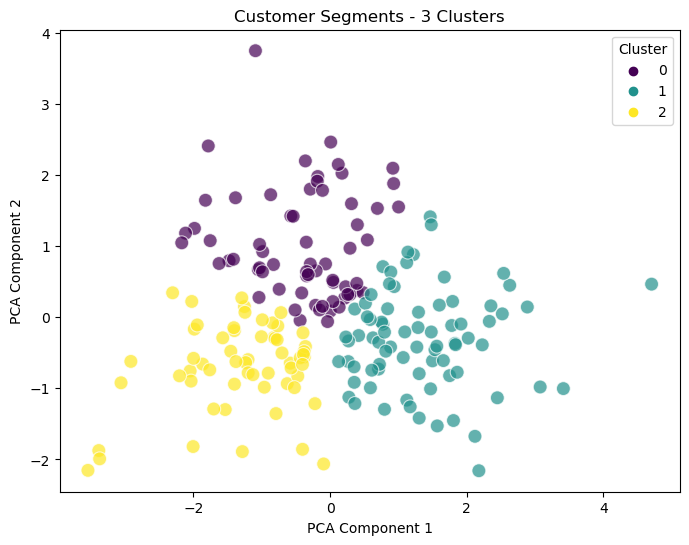

In [13]:
# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_profile, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title(f'Customer Segments - {num_clusters} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [13]:
# Output the clustering results
cluster_summary = customer_profile[['CustomerID', 'Cluster']].groupby('Cluster').count()
print(f"Cluster Summary:\n{cluster_summary}")

Cluster Summary:
         CustomerID
Cluster            
0                64
1                76
2                59


In [15]:
# Save clustering results to CSV
customer_profile[['CustomerID', 'Cluster']].to_csv('Customer_Segments.csv', index=False)
customer_profile

,CustomerID,total_spent,num_purchases,avg_purchase_value,region_Europe,region_North America,region_South America,Cluster,PCA1,PCA2
0,C0001,-0.061701,-0.011458,0.094670,0,0,1,0,0.002624,0.086226
1,C0002,-0.877744,-0.467494,-0.904016,0,0,0,2,-1.201170,-0.596660
2,C0003,-0.405857,-0.467494,-1.094109,0,0,1,2,-0.905175,-0.786111
3,C0004,1.032547,1.356650,-0.447702,0,0,1,1,1.471052,-1.007849
4,C0005,-0.783929,-0.923530,0.285581,0,0,0,0,-1.049722,0.671027
...,...,...,...,...,...,...,...,...,...,...
194,C0196,0.829053,-0.467494,2.089604,1,0,0,0,0.919034,2.096416
195,C0197,-0.841689,-0.923530,-0.643077,1,0,0,2,-1.408556,-0.147094
196,C0198,-1.386975,-1.379566,-0.461100,1,0,0,2,-2.024483,0.221787
197,C0199,-0.813993,-0.467494,-0.304206,1,0,0,2,-0.991641,-0.036728


In [16]:
# Print DB Index and Silhouette Score
print(f"Davies-Bouldin Index for {num_clusters} clusters: {db_index}")
print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg}")

Davies-Bouldin Index for 3 clusters: 1.2669664314894822
Silhouette Score for 3 clusters: 0.2628569889143938
